# Using the Fixed Variance process
The `FixedVariance` volatility process can be used to implement zig-zag model 
estimation where two steps are repeated until convergence.  This can be used 
to estimate models which may not be easy to estimate as a single process due
to numerical issues or a high-dimensional parameter space.

_This setup code is required to run in an IPython notebook_

In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn
seaborn.set_style('darkgrid')

In [2]:
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90
seaborn.mpl.rcParams['font.family'] = 'serif'
seaborn.mpl.rcParams['font.size'] = 14

### Setup

Imports used in this example.

In [3]:
import datetime as dt
import numpy as np
from pandas_datareader import data

## Data
The VIX index will be used to illustrate the use of the `FixedVariance` process.  The data is read using `pandas-datareader`.

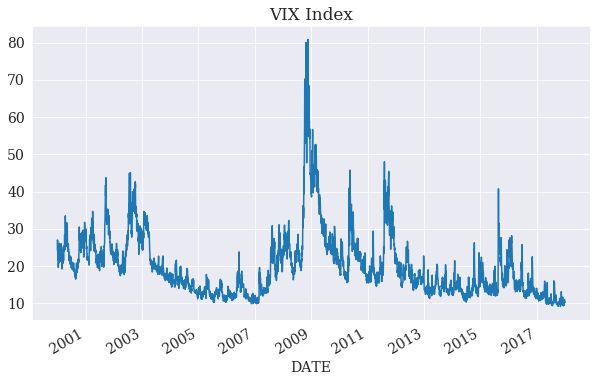

In [4]:
dr = data.FredReader('VIXCLS', dt.datetime(2000, 1, 1), dt.datetime(2017, 12, 31))
vix_data = dr.read()
vix = vix_data.VIXCLS.dropna()
vix.name = 'VIX Index'
ax = vix.plot(title='VIX Index')

## Initial Mean Model Estimation
The first step is to estimate the mean to filter the residuals using a constant variance. 

In [5]:
from arch.univariate.mean import HARX, ZeroMean
from arch.univariate.volatility import GARCH, FixedVariance
mod = HARX(vix, lags=[1,5,22])
res = mod.fit()
print(res.summary())

                    HAR - Constant Variance Model Results                     
Dep. Variable:              VIX Index   R-squared:                       0.965
Mean Model:                       HAR   Adj. R-squared:                  0.965
Vol Model:          Constant Variance   Log-Likelihood:               -8600.27
Distribution:                  Normal   AIC:                           17210.5
Method:            Maximum Likelihood   BIC:                           17242.6
                                        No. Observations:                 4506
Date:                Thu, Sep 27 2018   Df Residuals:                     4501
Time:                        15:27:49   Df Model:                            5
                                    Mean Model                                    
                      coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------------------------
Const               0.2202      0.112   

## Initial Volatility Model Estimation
Using the previously estimated residuals, a volatility model can be estimated using a `ZeroMean`. In this example, a GJR-GARCH process is used for the variance.

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                  resid   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -7167.57
Distribution:                  Normal   AIC:                           14343.1
Method:            Maximum Likelihood   BIC:                           14368.8
                                        No. Observations:                 4506
Date:                Thu, Sep 27 2018   Df Residuals:                     4502
Time:                        15:27:49   Df Model:                            4
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0738  1.683e-02      4.382  1.174e-05 [4.077e-0

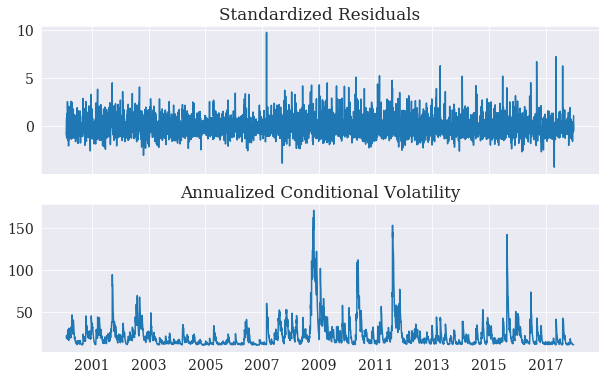

In [6]:
vol_mod = ZeroMean(res.resid.dropna(), volatility=GARCH(p=1,o=1,q=1))
vol_res = vol_mod.fit(disp='off')
print(vol_res.summary())
ax = vol_res.plot('D')

## Re-estimating the mean with a ``FixedVariance``
The `FixedVariance` requires that the variance is provided when initializing the object.  The variance provided should have the same shape as the original data.  Since the variance estimated from the GJR-GARCH model is missing the first 22 observations due to the HAR lags, we simply fill these with 1.  These values will not be used to estimate the model, and so the value is not important. 

The summary shows that there is a single parameter, ``scale``, which is close to 1. The mean parameters
have changed which reflects the GLS-like weighting that this re-estimaion imposes.

In [7]:
variance = np.empty_like(vix)
variance.fill(1.0)
variance[22:] = vol_res.conditional_volatility ** 2.0
fv = FixedVariance(variance)
mod = HARX(vix, lags=[1,5,22], volatility=fv)
res = mod.fit()
print(res.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 7167.56600290707
Iteration:      2,   Func. Count:     21,   Neg. LLF: 7167.542807019507
Iteration:      3,   Func. Count:     32,   Neg. LLF: 7164.798624995907
Iteration:      4,   Func. Count:     43,   Neg. LLF: 7162.605127839062
Iteration:      5,   Func. Count:     53,   Neg. LLF: 7162.600913736296
Iteration:      6,   Func. Count:     63,   Neg. LLF: 7162.600864075792
Iteration:      7,   Func. Count:     70,   Neg. LLF: 7162.600859729137
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7162.6008597291375
            Iterations: 7
            Function evaluations: 70
            Gradient evaluations: 7
                      HAR - Fixed Variance Model Results                      
Dep. Variable:              VIX Index   R-squared:                       0.965
Mean Model:                       HAR   Adj. R-squared:                  0.965
Vol Model:             Fixed Variance   Log-Likelih

## Zig-Zag estimation
A small repetitions of the previous two steps can be used to implement a so-called zig-zag estimation strategy.

In [8]:
for i in range(5):
    print(i)
    vol_mod = ZeroMean(res.resid.dropna(), volatility=GARCH(p=1,o=1,q=1))
    vol_res = vol_mod.fit(disp='off')
    variance[22:] = vol_res.conditional_volatility ** 2.0
    fv = FixedVariance(variance, unit_scale=True)
    mod = HARX(vix, lags=[1,5,22], volatility=fv)
    res = mod.fit(disp='off')
print(res.summary())

0
1
2
3
4
                    HAR - Fixed Variance (Unit Scale) Model Results                    
Dep. Variable:                       VIX Index   R-squared:                       0.965
Mean Model:                                HAR   Adj. R-squared:                  0.965
Vol Model:         Fixed Variance (Unit Scale)   Log-Likelihood:               -7165.87
Distribution:                           Normal   AIC:                           14339.7
Method:                     Maximum Likelihood   BIC:                           14365.4
                                                 No. Observations:                 4506
Date:                         Thu, Sep 27 2018   Df Residuals:                     4502
Time:                                 15:27:50   Df Model:                            4
                                    Mean Model                                   
                      coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------

## Direct Estimation
This model can be directly estimated.  The results are provided for comparisson to the previous 
``FixedVariance`` estimates of the mean parameters.

In [9]:
mod = HARX(vix, lags=[1,5,22], volatility=GARCH(1,1,1))
res = mod.fit(disp='off')
print(res.summary())

                        HAR - GJR-GARCH Model Results                         
Dep. Variable:              VIX Index   R-squared:                       0.965
Mean Model:                       HAR   Adj. R-squared:                  0.965
Vol Model:                  GJR-GARCH   Log-Likelihood:               -7159.40
Distribution:                  Normal   AIC:                           14334.8
Method:            Maximum Likelihood   BIC:                           14386.1
                                        No. Observations:                 4506
Date:                Thu, Sep 27 2018   Df Residuals:                     4498
Time:                        15:27:50   Df Model:                            8
                                    Mean Model                                   
                      coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------------------------------------
Const               0.3235  9.679e-02      